# Poisson process fit to start times

Import packages & configure plots for dark mode:

In [10]:
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

Calculate and display the outliers in the rates:

In [11]:
rates = list(rates_dict.values())
cutoff = np.mean(rates) + 1.5*np.std(rates) # clearly nothing at minus 1.5sigma
max_rate = max(rates)
max_keys = [key for key, val in rates_dict.items() if val >= cutoff]
outliers = [get_station_name(i) for i in max_keys]
outliers

['Lexham Gardens, Kensington',
 'Queensway, Westminster',
 'Foley Street, Fitzrovia',
 'Marloes Road, Kensington',
 'Granby Street, Shoreditch',
 'South Quay East, Canary Wharf',
 'Devons Road, Bow',
 'Westminster Bridge Road, Elephant & Castle',
 'Shoreditch Court, Haggerston',
 'Belford House, Haggerston',
 'Temple Gardens, Temple']

In [12]:
np.mean(rates)

0.08087406516250945

Calculate the p-values for the different stations using the inter arrival times and the exponential distribution:

In [13]:
p_values = {}

for station in test_sorted_stations:
    station_id = station.start_id.unique()[0]
    rate = rates_dict[station_id]
    inter_arrival_times = station.start_time.diff().to_numpy() 
    inter_arrival_times[0] = station.start_time.to_numpy()[0] # change first inter-arrival time to t_1
    station_p_values = np.exp(-1* rate * inter_arrival_times)
    p_values[station_id] = station_p_values

p_values[1]

array([0.00000000e+00, 2.36089578e-11, 1.73179091e-01, 3.87127632e-03,
       2.62471653e-03, 8.04426401e-02, 3.13439657e-01, 5.25770589e-02,
       7.79576546e-04, 4.03666761e-07, 7.67540343e-03, 4.51248913e-01,
       9.79888158e-01, 9.47779597e-02, 2.21046390e-03, 3.81475755e-02,
       1.09325487e-12, 6.73756574e-17, 7.42144726e-01, 5.36126077e-01,
       1.87137759e-01, 5.05796737e-02, 4.36695083e-01, 2.85280722e-05,
       9.79733399e-01, 4.86539138e-01, 3.83159477e-02, 7.08982073e-01,
       8.85534367e-01, 1.55703975e-03, 1.34806000e-08, 5.61999326e-02,
       5.68578472e-02, 6.11946253e-01, 9.13550123e-01, 1.19556481e-01,
       5.38200965e-01, 9.54180993e-04, 2.63890761e-01, 2.15223668e-01,
       3.74438046e-19, 6.29492028e-04, 4.12219737e-05, 3.80448222e-01,
       2.04269915e-05, 2.75551316e-06, 1.97195561e-06, 4.96780735e-02,
       7.66460764e-01, 8.88811300e-01, 7.34144134e-01, 9.14318538e-01,
       2.33090392e-01, 3.54019063e-28, 8.60806273e-01, 8.60882917e-01,
      

Histogram of the p-values:

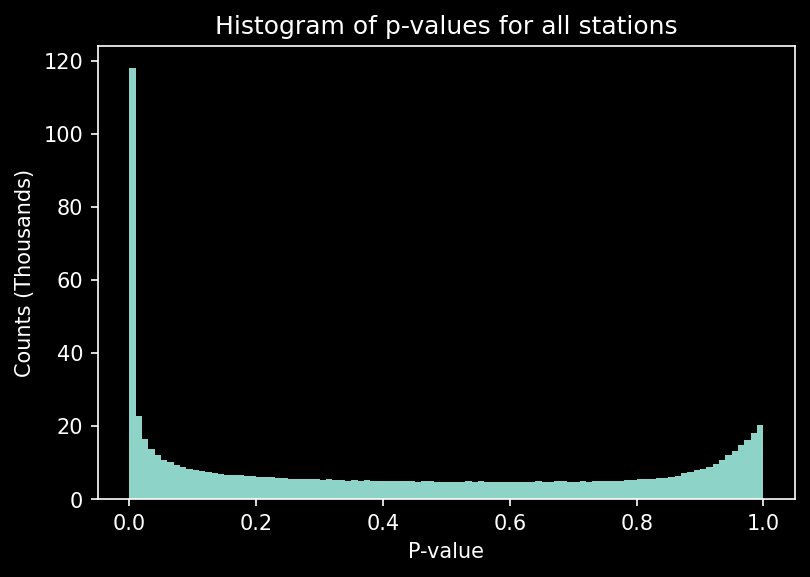

In [14]:
joined_p_values = np.concatenate(np.array(list(p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values.png")
plt.show()

Carry out and plot the Kolmogorov-Smirnov test on all the p-values to see if the poisson point process model is a good model for our data:

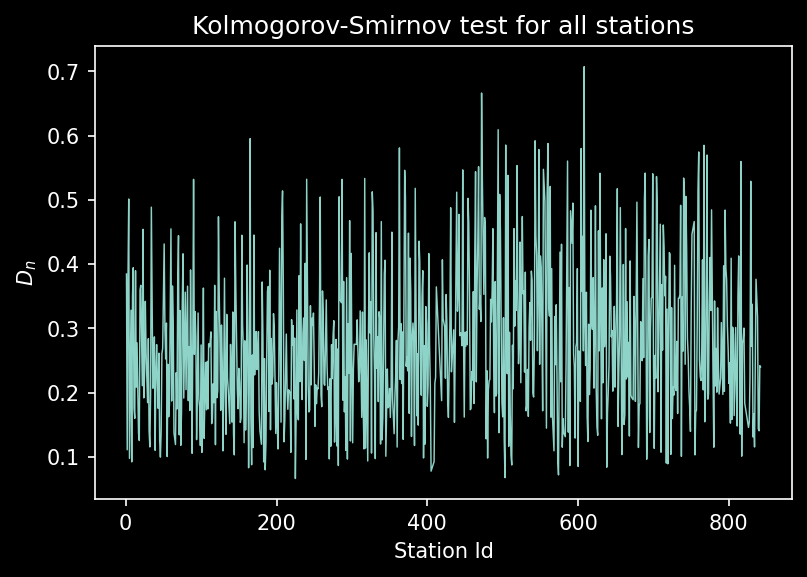

In [15]:
# Kolmogorov-smirnov:
kol_smir_test = {}
for station_id, pvals in p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir.png")
plt.show()

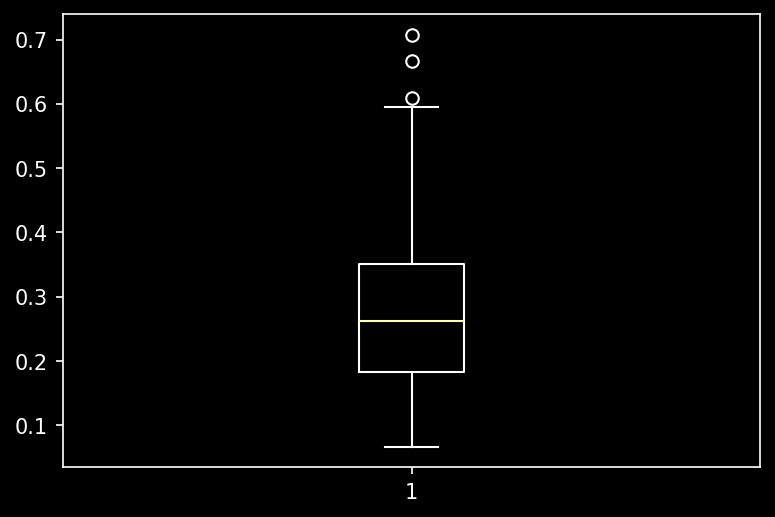

In [16]:
plt.boxplot(kol_smir_test.values())
plt.show()

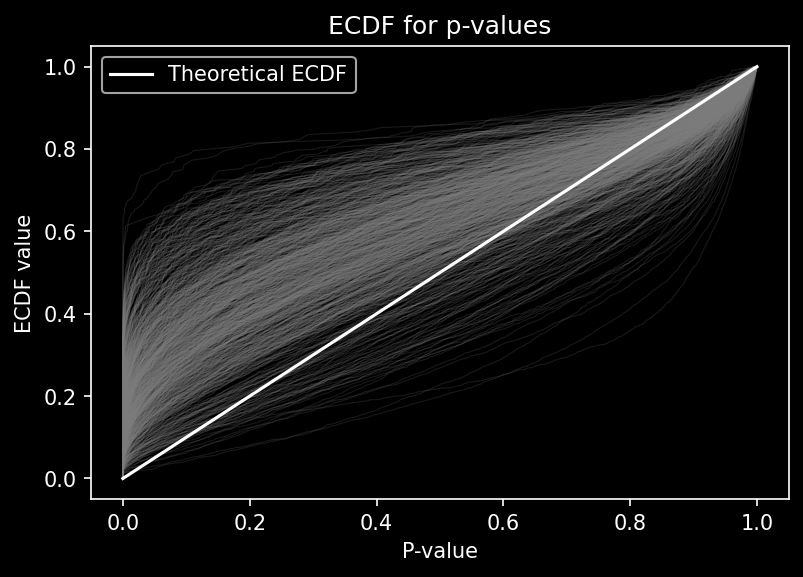

In [17]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

for station, pvals in p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()